In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')
# 预测第二天用药，第一天当做历史信息,前100种
x = df.iloc[:,5:5+72+2000+300]
y = df.iloc[:,5+72+2000+300:5+72+2000+300+100]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)

# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)





In [5]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test,  
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=256,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l2(0.001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




create model. feature_dim =2372, label_dim =100
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               607488    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 100)               25700     
                                                                 
Total params: 698,980
Trainable params: 698,980
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 7ms/step - loss: 0.8166 - JI: 0.0527 - val_loss: 0.2533 - val_JI: 0.0473
Epoch 2/500
110/110 [==============================] - 1s 6ms/step - loss: 0.2424 - JI: 0.0631 - val_loss: 0.2096 - val_JI: 0.0651
Ep

110/110 [==============================] - 1s 6ms/step - loss: 0.1436 - JI: 0.2292 - val_loss: 0.1493 - val_JI: 0.2026
Epoch 57/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1424 - JI: 0.2358 - val_loss: 0.1511 - val_JI: 0.2075
Epoch 58/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1413 - JI: 0.2400 - val_loss: 0.1492 - val_JI: 0.2006
Epoch 59/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1420 - JI: 0.2377 - val_loss: 0.1502 - val_JI: 0.2032
Epoch 60/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1407 - JI: 0.2414 - val_loss: 0.1489 - val_JI: 0.2047
Epoch 61/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1395 - JI: 0.2472 - val_loss: 0.1489 - val_JI: 0.1939
Epoch 62/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1396 - JI: 0.2477 - val_loss: 0.1512 - val_JI: 0.1885
Epoch 63/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1398 - JI: 

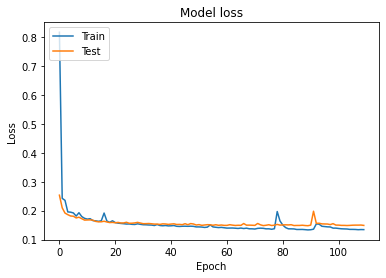

验证集上的最优结果是0.23143798112869263,对应训练轮次是86


0.23143798112869263

In [6]:
train_DNN(X_train,y_train,X_test,y_test)

create model. feature_dim =2372, label_dim =100
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               607488    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 100)               25700     
                                                                 
Total 

110/110 [==============================] - 1s 8ms/step - loss: 0.1443 - JI: 0.2214 - val_loss: 0.1499 - val_JI: 0.2062
Epoch 54/500
110/110 [==============================] - 1s 8ms/step - loss: 0.2135 - JI: 0.2188 - val_loss: 0.1496 - val_JI: 0.1975
Epoch 55/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1469 - JI: 0.2249 - val_loss: 0.1480 - val_JI: 0.2051
Epoch 56/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1429 - JI: 0.2294 - val_loss: 0.1485 - val_JI: 0.1907
Epoch 57/500
110/110 [==============================] - 1s 8ms/step - loss: 0.2176 - JI: 0.2257 - val_loss: 0.1494 - val_JI: 0.1984
Epoch 58/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1425 - JI: 0.2293 - val_loss: 0.1491 - val_JI: 0.2141
Epoch 59/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1464 - JI: 0.2257 - val_loss: 0.1495 - val_JI: 0.1939
Epoch 60/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1423 - JI: 

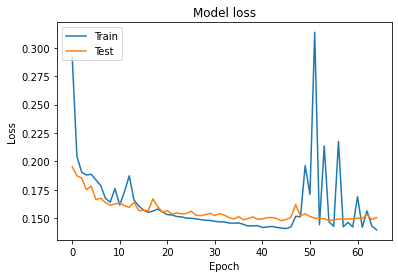

验证集上的最优结果是0.21942663192749023,对应训练轮次是62


0.21942663192749023

In [7]:
train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num=4)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')
# 预测第二天用药，第一天当做历史信息,前50种
x = df.iloc[:,5:5+72+2000+300]
y = df.iloc[:,5+72+2000+300:5+72+2000+300+50]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)

# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)





create model. feature_dim =2372, label_dim =50
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               607488    
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 50)                12850     
                                                                 
Total params: 686,130
Trainable params: 686,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 7ms/step - loss: 1.0449 - JI: 0.0636 - val_loss: 0.2748 - val_JI: 0.0571
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.2992 - JI: 0.0816 - val_loss: 0.2777 - val_JI: 0.0827
Epo

110/110 [==============================] - 1s 6ms/step - loss: 0.1991 - JI: 0.2410 - val_loss: 0.2121 - val_JI: 0.2270
Epoch 57/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1965 - JI: 0.2500 - val_loss: 0.2084 - val_JI: 0.2178
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1946 - JI: 0.2549 - val_loss: 0.2089 - val_JI: 0.2126
Epoch 59/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1995 - JI: 0.2448 - val_loss: 0.2120 - val_JI: 0.2003
Epoch 60/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1969 - JI: 0.2510 - val_loss: 0.2116 - val_JI: 0.2253
Epoch 61/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1955 - JI: 0.2535 - val_loss: 0.2091 - val_JI: 0.2246
Epoch 62/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1933 - JI: 0.2616 - val_loss: 0.2079 - val_JI: 0.2296
Epoch 63/500
110/110 [==============================] - 1s 6ms/step - loss: 0.1905 - JI: 

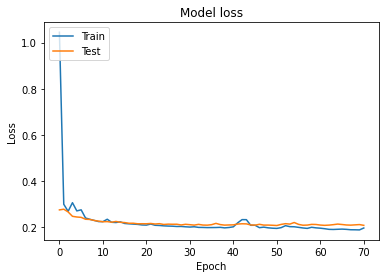

验证集上的最优结果是0.23798584938049316,对应训练轮次是63


0.23798584938049316

In [9]:
# 预测前50个
train_DNN(X_train,y_train,X_test,y_test)